In [1]:
import os
import h5py
import pandas as pd
from lbn import LBN, LBNLayer
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras import datasets, layers, models
from keras.optimizers import Adam
from tensorflow.keras.regularizers import l1
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [6]:
import tensorflow as tf
print(tf.__version__)
print(dir(tf.feature_column))


2.3.0
['__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', '_sys', 'bucketized_column', 'categorical_column_with_hash_bucket', 'categorical_column_with_identity', 'categorical_column_with_vocabulary_file', 'categorical_column_with_vocabulary_list', 'crossed_column', 'embedding_column', 'indicator_column', 'make_parse_example_spec', 'numeric_column', 'sequence_categorical_column_with_hash_bucket', 'sequence_categorical_column_with_identity', 'sequence_categorical_column_with_vocabulary_file', 'sequence_categorical_column_with_vocabulary_list', 'sequence_numeric_column', 'shared_embeddings', 'weighted_categorical_column']


In [2]:
physical_devices = tf.config.list_physical_devices('GPU') 
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
#tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available:  1


In [3]:
f = h5py.File('../data/processed-pythia82-lhc13-all-pt1-50k-r1_h022_e0175_t220_nonu_withPars_truth_0.z', 'r')
treeArray = f['t_allpar_new'][()]
print(treeArray.dtype.names)

('index', 'j_ptfrac', 'j_pt', 'j_eta', 'j_mass', 'j_tau1_b1', 'j_tau2_b1', 'j_tau3_b1', 'j_tau1_b2', 'j_tau2_b2', 'j_tau3_b2', 'j_tau32_b1', 'j_tau32_b2', 'j_zlogz', 'j_c1_b0', 'j_c1_b1', 'j_c1_b2', 'j_c2_b1', 'j_c2_b2', 'j_d2_b1', 'j_d2_b2', 'j_d2_a1_b1', 'j_d2_a1_b2', 'j_m2_b1', 'j_m2_b2', 'j_n2_b1', 'j_n2_b2', 'j_tau1_b1_mmdt', 'j_tau2_b1_mmdt', 'j_tau3_b1_mmdt', 'j_tau1_b2_mmdt', 'j_tau2_b2_mmdt', 'j_tau3_b2_mmdt', 'j_tau32_b1_mmdt', 'j_tau32_b2_mmdt', 'j_c1_b0_mmdt', 'j_c1_b1_mmdt', 'j_c1_b2_mmdt', 'j_c2_b1_mmdt', 'j_c2_b2_mmdt', 'j_d2_b1_mmdt', 'j_d2_b2_mmdt', 'j_d2_a1_b1_mmdt', 'j_d2_a1_b2_mmdt', 'j_m2_b1_mmdt', 'j_m2_b2_mmdt', 'j_n2_b1_mmdt', 'j_n2_b2_mmdt', 'j_mass_trim', 'j_mass_mmdt', 'j_mass_prun', 'j_mass_sdb2', 'j_mass_sdm1', 'j_multiplicity', 'j1_px', 'j1_py', 'j1_pz', 'j1_e', 'j1_pdgid', 'j1_erel', 'j1_pt', 'j1_ptrel', 'j1_eta', 'j1_etarel', 'j1_etarot', 'j1_phi', 'j1_phirel', 'j1_phirot', 'j1_deltaR', 'j1_costheta', 'j1_costhetarel', 'j1_e1mcosthetarel', 'j_g', 'j_q', 

In [4]:
features = ["j1_px","j1_py","j1_pz","j1_e"]
index = ["j_index"]
labels = ['j_q', 'j_g', 'j_w', 'j_z', 'j_t']

In [5]:
features_labels_df = pd.DataFrame(treeArray,columns=list(set(features+labels+index)))
features_labels_df = features_labels_df.drop_duplicates()
features_labels_df = features_labels_df[features+labels+index]

In [6]:
features_labels_df

,j1_px,j1_py,j1_pz,j1_e,j_q,j_g,j_w,j_z,j_t,j_index
0,-324.164185,11.356107,586.904724,670.573242,0,1,0,0,0,101333
1,-90.457199,2.882812,161.557922,185.180466,0,1,0,0,0,101333
2,-79.528648,2.860313,144.850616,165.272293,0,1,0,0,0,101333
3,-35.328690,1.361764,66.346008,75.178345,0,1,0,0,0,101333
4,-33.074738,1.491175,58.857586,67.530716,0,1,0,0,0,101333
...,...,...,...,...,...,...,...,...,...,...
5131608,-0.415659,0.057546,-0.005245,0.419657,0,0,0,1,0,300123134
5131609,-0.280913,-0.129759,-0.041120,0.312155,0,0,0,1,0,300123134
5131610,-0.236488,-0.113574,-0.013780,0.262708,0,0,0,1,0,300123134
5131611,-0.139301,0.008023,-0.008028,0.139763,0,0,0,1,0,300123134


In [7]:
def numJets(n):
    num = 0
    for i in features_labels_df[n].values:
        if i ==1:
            num += 1
    return num

In [8]:
for label in labels:
    nJet = numJets(label)
    print("number of jets in " + str(label) + ": " + str(nJet))

number of jets in j_q: 776366
number of jets in j_g: 1399788
number of jets in j_w: 798037
number of jets in j_z: 828324
number of jets in j_t: 1329098


In [9]:
low_features = ['j1_px', 'j1_py', 'j1_pz', 'j1_e', 'j1_pdgid', 
            'j1_erel', 'j1_pt', 'j1_ptrel', 'j1_eta', 'j1_etarel', 
             'j1_etarot', 'j1_phi', 'j1_phirel', 'j1_phirot', 
            'j1_deltaR', 'j1_costheta', 'j1_costhetarel', 
             'j1_e1mcosthetarel']
low_features_df = pd.DataFrame(treeArray, columns = low_features + labels)

In [10]:
def low_1D(feature):
    plt.clf
    name = [feature] + labels
    featLabsval = low_features_df[name].values
    
    quark = []
    gluon = []
    w= []
    z= []
    top = []
    
    for x in featLabsval:
        if x[1] == 1:
            quark.append(x[0])
        if x[2] == 1:
            gluon.append(x[0])
        if x[3] == 1:
            w.append(x[0])
        if x[4] == 1:
            z.append(x[0])
        if x[5] == 1:
            top.append(x[0])
            
    plt.hist(gluon,50,histtype='step',density = True, log = True, label = 'gluon',color = 'blue')
    plt.hist(quark,50,histtype='step',density = True, log = True, label = 'quark',color = 'red')
    plt.hist(w,50,histtype='step',density = True, log = True, label = 'W',color = 'black')
    plt.hist(z,50,histtype='step',density = True, log = True, label = 'Z',color = 'green')
    plt.hist(top,50,histtype='step',density = True, log = True, label = 'top',color = 'purple')
    plt.xlabel(feature)
    plt.ylabel('Prob. Density (a.u.)')
    plt.legend()
    plt.show()

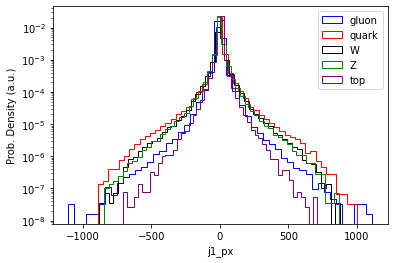

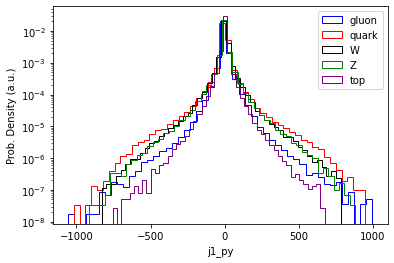

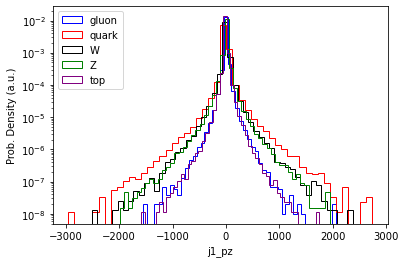

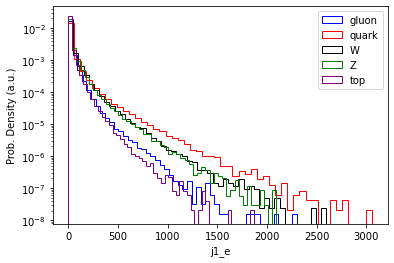

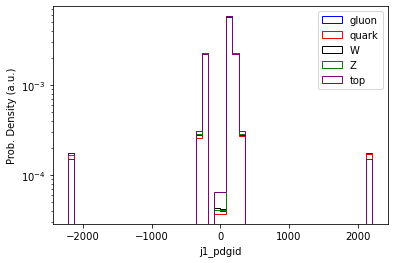

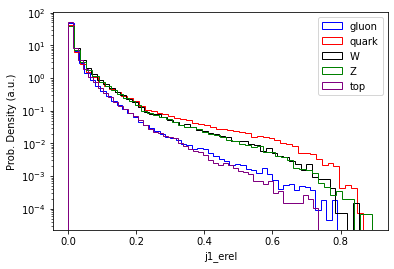

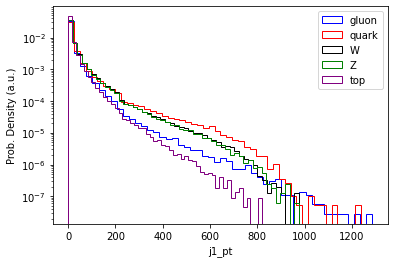

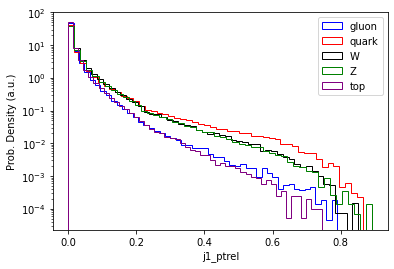

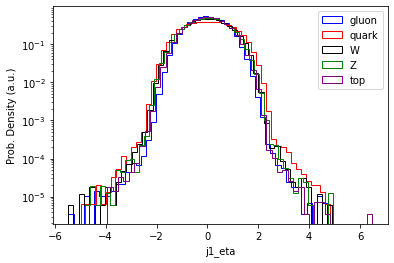

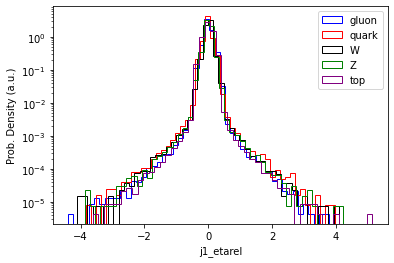

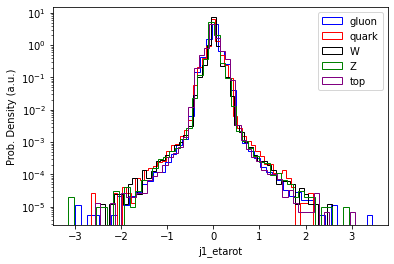

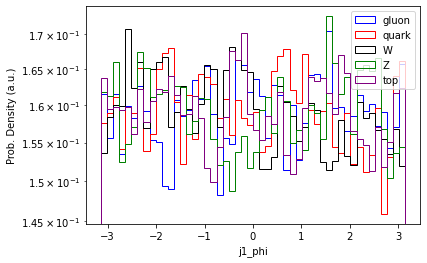

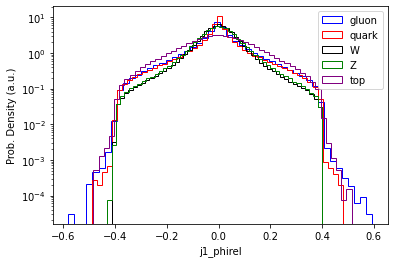

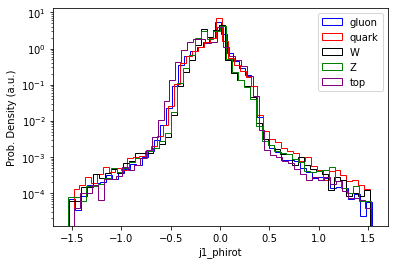

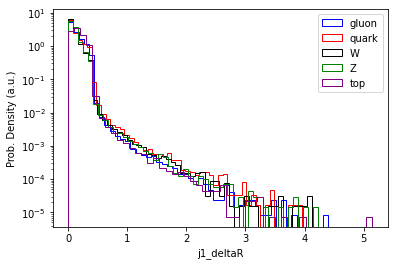

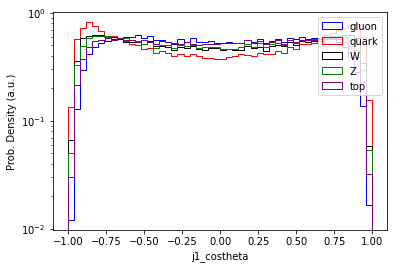

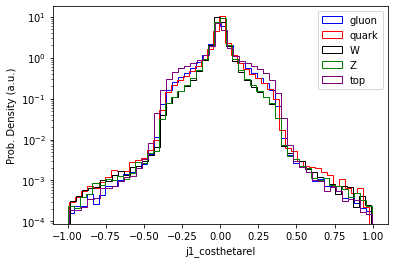

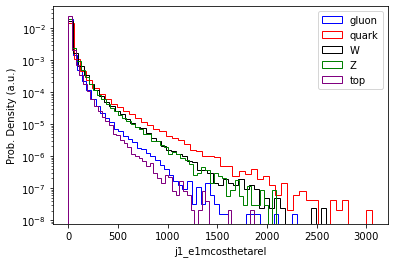

In [11]:
for y in low_features:
    low_1D(y)

In [10]:
features_labels_df.head()

,j1_px,j1_py,j1_pz,j1_e,j_q,j_g,j_w,j_z,j_t,j_index
0,-324.164185,11.356107,586.904724,670.573242,0,1,0,0,0,101333
1,-90.457199,2.882812,161.557922,185.180466,0,1,0,0,0,101333
2,-79.528648,2.860313,144.850616,165.272293,0,1,0,0,0,101333
3,-35.328690,1.361764,66.346008,75.178345,0,1,0,0,0,101333
4,-33.074738,1.491175,58.857586,67.530716,0,1,0,0,0,101333


In [11]:
unique_jindex = features_labels_df['j_index'].unique()

unique_count = features_labels_df['j_index'].value_counts()
unique_count

132349       202
112811       193
96881        176
77686        174
114189       167
            ... 
100114426      8
100087725      8
100026279      8
100118920      7
100174844      7
Name: j_index, Length: 98769, dtype: int64

In [36]:
test_impute = features_labels_df.loc[features_labels_df['j_index']==100174844].copy()
#while len(test_impute) != 13:
    #test_impute.loc[(len(test_impute))] = 0


In [37]:
test_impute.loc[8]

KeyError: 8

In [33]:
test_impute


,j1_px,j1_py,j1_pz,j1_e,j_q,j_g,j_w,j_z,j_t,j_index
2026487,425.167847,-541.827393,-741.974915,1012.359314,1,0,0,0,0,100174844
2026488,94.138077,-119.352165,-165.442444,224.673355,1,0,0,0,0,100174844
2026489,86.045631,-108.494881,-150.770065,204.711075,1,0,0,0,0,100174844
2026490,28.393793,-35.463280,-49.446808,67.148026,1,0,0,0,0,100174844
2026491,16.496531,-20.595251,-28.816910,39.073193,1,0,0,0,0,100174844
2026492,10.881019,-13.795407,-18.993179,25.873745,1,0,0,0,0,100174844
2026493,2.806478,-2.038203,-2.747490,4.522076,1,0,0,0,0,100174844


In [14]:
df13 = pd.DataFrame(features_labels_df)
to_remove =unique_count[unique_count < 13].index
df13 = df13[~df13.j_index.isin(to_remove)]

In [15]:
unique13_jindex = df13['j_index'].unique()
unique13_jindex

array([   101333, 100073064, 300177633, ..., 400153985, 300037743,
       300123134])

In [17]:
data13 = df13.groupby('j_index').head(13)

In [18]:
data13.head()

,j1_px,j1_py,j1_pz,j1_e,j_q,j_g,j_w,j_z,j_t,j_index
0,-324.164185,11.356107,586.904724,670.573242,0,1,0,0,0,101333
1,-90.457199,2.882812,161.557922,185.180466,0,1,0,0,0,101333
2,-79.528648,2.860313,144.850616,165.272293,0,1,0,0,0,101333
3,-35.328690,1.361764,66.346008,75.178345,0,1,0,0,0,101333
4,-33.074738,1.491175,58.857586,67.530716,0,1,0,0,0,101333


In [19]:
test_numpy = np.zeros((98688,13,4)) # feature array
label_numpy = np.zeros((98688,13,5)) # label array

for i in range(len(unique13_jindex)):
    #print(i)
    test_index = data13.loc[data13['j_index'] == unique13_jindex[i]].to_numpy()
    test_numpy[i]=test_index[:,0:4]
    label_numpy[i] = test_index[:,4:9]
    
    

In [20]:
label_numpy[0]

array([[0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [21]:

indx = np.random.permutation(label_numpy.shape[0])
train_idx, test_idx = indx[:88000], indx[88000:]
x_train, x_test, y_train, y_test = test_numpy[train_idx,:], test_numpy[test_idx,:], label_numpy[train_idx,:],label_numpy[test_idx,:]


In [23]:
y_train = y_train[:,0,:]
y_test = y_test[:,0,:]

In [24]:
y_test.shape

(10688, 5)

In [25]:
x_train = x_train.reshape((-1, 13, 4))
y_train = y_train.reshape((-1,5))
x_test = x_test.reshape((-1,13,4))
y_test = y_test.reshape((-1,5))

len(y_train)

88000

In [44]:
input_shape = (13,4)

inputs = keras.Input(shape=input_shape)

x = LBNLayer(input_shape, 13, boost_mode=LBN.PAIRS, features=["E", "pt", "eta", "phi", "m", "pair_cos"])(inputs)

x = Dense(1024, kernel_initializer='lecun_uniform', kernel_regularizer='l2', activation='elu', name='fc1_elu')(x)
x = BatchNormalization()(x)
x = Dense(1024, kernel_initializer='lecun_uniform', kernel_regularizer='l2', activation='elu', name='fc2_elu')(x)
x = BatchNormalization()(x)
x = Dense(1024, kernel_initializer='lecun_uniform', kernel_regularizer='l2', activation='elu', name='fc3_elu')(x)
x = BatchNormalization()(x)
x = Dense(1024, kernel_initializer='lecun_uniform', kernel_regularizer='l2', activation='elu', name='fc4_elu')(x)
x = BatchNormalization()(x)
x = Dense(1024, kernel_initializer='lecun_uniform', kernel_regularizer='l2', activation='elu', name='fc5_elu')(x)
x = BatchNormalization()(x)
x = Dense(1024, kernel_initializer='lecun_uniform', kernel_regularizer='l2', activation='elu', name='fc6_elu')(x)
x = BatchNormalization()(x)
x = Dense(1024, kernel_initializer='lecun_uniform', kernel_regularizer='l2', activation='elu', name='fc7_elu')(x)
x = BatchNormalization()(x)
x = Dense(1024, kernel_initializer='lecun_uniform', kernel_regularizer='l2', activation='elu', name='fc8_elu')(x)
x = BatchNormalization()(x)
outputs = Dense(5, kernel_initializer='lecun_uniform', kernel_regularizer='l2', activation='softmax', name='output_softmax')(x)

model = keras.Model(inputs=inputs, outputs=outputs, name="lbn-five")

In [45]:
adam = Adam(lr=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [46]:
model.summary()

Model: "lbn-five"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 13, 4)]           0         
_________________________________________________________________
LBN (LBNLayer)               (None, 143)               338       
_________________________________________________________________
fc1_elu (Dense)              (None, 1024)              147456    
_________________________________________________________________
batch_normalization_16 (Batc (None, 1024)              4096      
_________________________________________________________________
fc2_elu (Dense)              (None, 1024)              1049600   
_________________________________________________________________
batch_normalization_17 (Batc (None, 1024)              4096      
_________________________________________________________________
fc3_elu (Dense)              (None, 1024)              104

In [64]:
history = model.fit(x_train, y_train, batch_size = 512, epochs = 200, 
                    validation_split = 0.1, shuffle = False, callbacks = None,
                    use_multiprocessing=True, workers=4)

Train on 79200 samples, validate on 8800 samples
Epoch 1/200
79200/79200 [==============================] - 4s 55us/sample - loss: 1.3166 - accuracy: 0.4617 - val_loss: 1.3505 - val_accuracy: 0.4407
Epoch 2/200
79200/79200 [==============================] - 4s 55us/sample - loss: 1.3140 - accuracy: 0.4642 - val_loss: 1.3515 - val_accuracy: 0.4305
Epoch 3/200
79200/79200 [==============================] - 4s 55us/sample - loss: 1.3134 - accuracy: 0.4649 - val_loss: 1.4280 - val_accuracy: 0.4159
Epoch 4/200
79200/79200 [==============================] - 4s 55us/sample - loss: 1.3152 - accuracy: 0.4638 - val_loss: 1.3700 - val_accuracy: 0.4405
Epoch 5/200
79200/79200 [==============================] - 4s 55us/sample - loss: 1.3134 - accuracy: 0.4641 - val_loss: 1.5329 - val_accuracy: 0.3725
Epoch 6/200
79200/79200 [==============================] - 4s 55us/sample - loss: 1.3135 - accuracy: 0.4651 - val_loss: 1.3766 - val_accuracy: 0.4299
Epoch 7/200
79200/79200 [==========================

Epoch 55/200
79200/79200 [==============================] - 4s 55us/sample - loss: 1.3079 - accuracy: 0.4665 - val_loss: 2.0390 - val_accuracy: 0.2926
Epoch 56/200
79200/79200 [==============================] - 4s 56us/sample - loss: 1.3060 - accuracy: 0.4666 - val_loss: 2.0659 - val_accuracy: 0.3602
Epoch 57/200
79200/79200 [==============================] - 4s 56us/sample - loss: 1.3050 - accuracy: 0.4679 - val_loss: 1.8625 - val_accuracy: 0.2943
Epoch 58/200
79200/79200 [==============================] - 4s 56us/sample - loss: 1.3027 - accuracy: 0.4686 - val_loss: 1.6218 - val_accuracy: 0.3532
Epoch 59/200
79200/79200 [==============================] - 4s 56us/sample - loss: 1.3047 - accuracy: 0.4686 - val_loss: 1.5148 - val_accuracy: 0.3784
Epoch 60/200
79200/79200 [==============================] - 5s 57us/sample - loss: 1.3006 - accuracy: 0.4695 - val_loss: 1.3855 - val_accuracy: 0.4397
Epoch 61/200
79200/79200 [==============================] - 4s 57us/sample - loss: 1.3046 - ac

Epoch 163/200
79200/79200 [==============================] - 4s 56us/sample - loss: 1.2822 - accuracy: 0.4790 - val_loss: 1.8422 - val_accuracy: 0.3915
Epoch 164/200
79200/79200 [==============================] - 4s 56us/sample - loss: 1.2837 - accuracy: 0.4794 - val_loss: 1.9532 - val_accuracy: 0.3935
Epoch 165/200
79200/79200 [==============================] - 4s 56us/sample - loss: 1.2846 - accuracy: 0.4780 - val_loss: 2.7609 - val_accuracy: 0.3611
Epoch 166/200
79200/79200 [==============================] - 4s 56us/sample - loss: 1.2893 - accuracy: 0.4761 - val_loss: 3.6791 - val_accuracy: 0.3467
Epoch 167/200
79200/79200 [==============================] - 4s 56us/sample - loss: 1.2814 - accuracy: 0.4793 - val_loss: 2.3794 - val_accuracy: 0.3823
Epoch 168/200
79200/79200 [==============================] - 4s 56us/sample - loss: 1.2852 - accuracy: 0.4785 - val_loss: 1.7295 - val_accuracy: 0.3682
Epoch 169/200
79200/79200 [==============================] - 5s 57us/sample - loss: 1.28

In [65]:
def learningCurve(history):
    plt.figure(figsize=(10,8))
    plt.plot(history.history['loss'], linewidth=1)
    plt.plot(history.history['val_loss'], linewidth=1)
    plt.title('Model Loss over Epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['training sample loss','validation sample loss'])
    plt.savefig('5_tag_learning_curve.png')
    plt.show()
    plt.close()

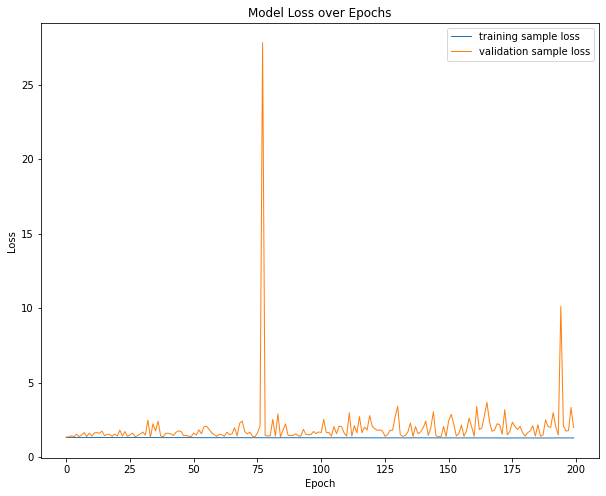

In [66]:
learningCurve(history)

In [67]:
labels_pred = model.predict(x_test)

In [68]:

def makeRoc(features_val, labels_val, labels, model, outputDir='', outputSuffix=''):
    from sklearn.metrics import roc_curve, auc
    labels_pred = model.predict(features_val)
    df = pd.DataFrame()
    fpr = {}
    tpr = {}
    auc1 = {}
    plt.figure(figsize=(10,8))       
    for i, label in enumerate(labels):
        df[label] = labels_val[:,i]
        df[label + '_pred'] = labels_pred[:,i]
        fpr[label], tpr[label], threshold = roc_curve(df[label],df[label+'_pred'])
        auc1[label] = auc(fpr[label], tpr[label])
        plt.plot(fpr[label],tpr[label],label='%s tagger, AUC = %.1f%%'%(label.replace('j_',''),auc1[label]*100.))
    plt.plot([0, 1], [0, 1], lw=1, color='black', linestyle='--')
    #plt.semilogy()
    plt.xlabel("Background Efficiency")
    plt.ylabel("Signal Efficiency")
    plt.xlim([-0.05, 1.05])
    plt.ylim(0.001,1.05)
    plt.grid(True)
    plt.legend(loc='lower right')
    plt.figtext(0.25, 0.90,'LBN ROC Curve',fontweight='bold', wrap=True, horizontalalignment='right', fontsize=14)
    #plt.figtext(0.35, 0.90,'preliminary', style='italic', wrap=True, horizontalalignment='center', fontsize=14) 
    #plt.savefig('%sROC_%s.pdf'%(outputDir, outputSuffix))
    plt.savefig('5_tag_ROC.png')
    return labels_pred

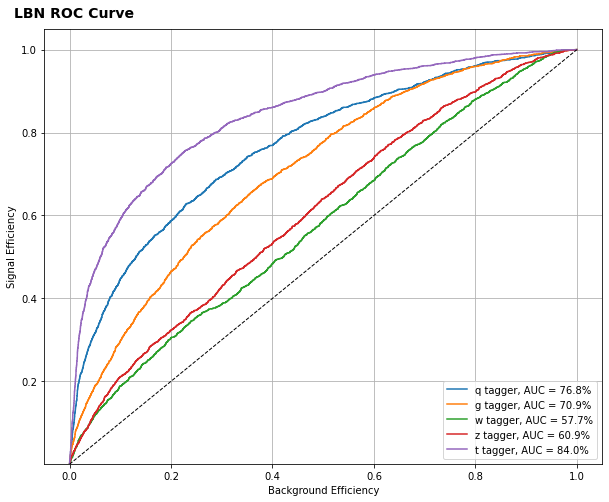

In [63]:
labels = ['j_q', 'j_g', 'j_w', 'j_z', 'j_t']
y_pred = makeRoc(x_test, y_test, labels, model, outputSuffix='lbn-5tag')